In [2]:
## Echo Python Version to be sure it is from virtual environment
import sys
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## Definitions
1. **Nominal interest** rates are set by government. 
Also, for different period (such as 5, 10, 15, etc.. **Zinsbindungszeit**) of fixed interest (**Zinsbindungsfrist**) have different rates.
Please [follow the graph](https://hypofriend.de/en/german-mortgage-calculator) to get present value of fixed interest rate for each period.
3. Annual bank **nominal interest rate** is compounded over 12 months. Therefore, **periodic interest rate** = nominal_interest_rate / 12
4. **Principal** amount does not include notary fees, real estate agent fees, grundwerbsteuer
5. We as customers can decide on **principal repayment rate**. Cannot be lesser than 1.5%
6. Fixed monthly payment can be derived by adding the periodic_interest_rate + periodic_prepayment_rate
7. Based on fixed monthly payments, we can then calculate how many years we need to pay the loan (**Annuitätendarlehen Laufzeit**)

### Example Amortized Fixed Monthly Payment Calculator
**number of compounding period** is fixed in the following case. <br/>
However, in reality this is calculated based on fixed monthly payment rate. <br/>
Following is an example using the amortized loan formula to calculate the fixed monthly payment

In [4]:
# Using the amortized loan formula, calculating the fixed monthly payments
PRINCIPAL_AMOUNT = 100000
BANK_INTEREST_RATE = 3.82 / 100
PREPAYMENT_RATE = 2.0
MONTHS_IN_YEAR = 12
ANNUAL_COMPOUNDING_PERIOD = MONTHS_IN_YEAR
PERIODIC_INTEREST_RATE = BANK_INTEREST_RATE/ANNUAL_COMPOUNDING_PERIOD
print("Periodic Interest Rate: ", PERIODIC_INTEREST_RATE)
TOTAL_COMPOUNDING_PERIODS = 28 * ANNUAL_COMPOUNDING_PERIOD
print("Total compounding period over 28 years: ", TOTAL_COMPOUNDING_PERIODS)
INTEREST_RATE_POW = math.pow((1 + PERIODIC_INTEREST_RATE), TOTAL_COMPOUNDING_PERIODS)

Fixed_Monthly_Payments = (PERIODIC_INTEREST_RATE * PRINCIPAL_AMOUNT * INTEREST_RATE_POW) / (INTEREST_RATE_POW - 1)
print("Fixed monthly payments: ", Fixed_Monthly_Payments)

Periodic Interest Rate:  0.003183333333333333
Total compounding period over 28 years:  336
Fixed monthly payments:  485.0639865985084


## Calculator of Loan Period (Annuitätendarlehen Laufzeit)
It can be calculated if following are known with this [formula](https://math.stackexchange.com/questions/3185889/how-do-i-solve-for-n-number-of-periods-in-a-loan-repayment-formula)
* **principal**
* **nominal interest rate**
* **principal repayment rate**

In [43]:
# YOU CAN VARY ONLY THE FOLLOWING VALUES
PRINCIPAL_AMOUNT = 420000
BANK_INTEREST_RATE = 3.82 / 100
PREPAYMENT_RATE = 2.0 / 100
MONTHS_IN_YEAR = 12

# Calculate Fixed Monthly Payments
ANNUAL_COMPOUNDING_PERIOD = MONTHS_IN_YEAR
PERIODIC_INTEREST_RATE = BANK_INTEREST_RATE / ANNUAL_COMPOUNDING_PERIOD
print("Periodic Interest Rate: ", PERIODIC_INTEREST_RATE)
PERIODIC_PRINCIPAL_REPAY_RATE = PREPAYMENT_RATE / ANNUAL_COMPOUNDING_PERIOD
print("Periodic Principal Repayment Rate: ", PERIODIC_PRINCIPAL_REPAY_RATE)
FIXED_MONTHLY_PAYMENT = (PERIODIC_INTEREST_RATE + PERIODIC_PRINCIPAL_REPAY_RATE) * PRINCIPAL_AMOUNT
print("Fixed monthly payment: ", FIXED_MONTHLY_PAYMENT)

# Calculate Total Loan Period
LOAN_PERIOD = math.log(FIXED_MONTHLY_PAYMENT / (FIXED_MONTHLY_PAYMENT - (PERIODIC_INTEREST_RATE * PRINCIPAL_AMOUNT)), 1 + PERIODIC_INTEREST_RATE)
LOAN_PERIOD_IN_YEARS = LOAN_PERIOD / MONTHS_IN_YEAR
print("Number of years to payback the loan: ", LOAN_PERIOD_IN_YEARS)

Periodic Interest Rate:  0.003183333333333333
Periodic Principal Repayment Rate:  0.0016666666666666668
Fixed monthly payment:  2037.0
Number of years to payback the loan:  28.006605346853178


## Calculate Total Interest Paid at the end of loan period

In [44]:
starting_data = {
    "princip_remain": [PRINCIPAL_AMOUNT],
    "princip_repaid_amt": [0],
    "interest_paid_amt": [0],
    "monthly_payment": [0]
}
periodic_loan_calc = pd.DataFrame(starting_data)
for prev_period_num in range(int(LOAN_PERIOD)):
    principal_prev_period = periodic_loan_calc.at[prev_period_num, "princip_remain"]
    interest_paid = PERIODIC_INTEREST_RATE * principal_prev_period
    principal_repaid = FIXED_MONTHLY_PAYMENT - interest_paid
    remaining_principal_amt = principal_prev_period - principal_repaid
    period_data = {
        "princip_remain": remaining_principal_amt,
        "princip_repaid_amt": principal_repaid,
        "interest_paid_amt": interest_paid,
        "monthly_payment": principal_repaid + interest_paid
    }
    period_df = pd.DataFrame([period_data])
    periodic_loan_calc = pd.concat([periodic_loan_calc, period_df], ignore_index=True)
    periodic_loan_calc = periodic_loan_calc.round(decimals=2)

print(periodic_loan_calc)

total_interest_paid = periodic_loan_calc['interest_paid_amt'].sum()
print("Total Interest paid at the end of the loan period: ", total_interest_paid)

     princip_remain  princip_repaid_amt  interest_paid_amt  monthly_payment
0         420000.00                0.00               0.00              0.0
1         419300.00              700.00            1337.00           2037.0
2         418597.77              702.23            1334.77           2037.0
3         417893.31              704.46            1332.54           2037.0
4         417186.60              706.71            1330.29           2037.0
..              ...                 ...                ...              ...
332         8242.58             2004.38              32.62           2037.0
333         6231.82             2010.76              26.24           2037.0
334         4214.66             2017.16              19.84           2037.0
335         2191.08             2023.58              13.42           2037.0
336          161.05             2030.03               6.97           2037.0

[337 rows x 4 columns]
Total Interest paid at the loan period:  264593.05


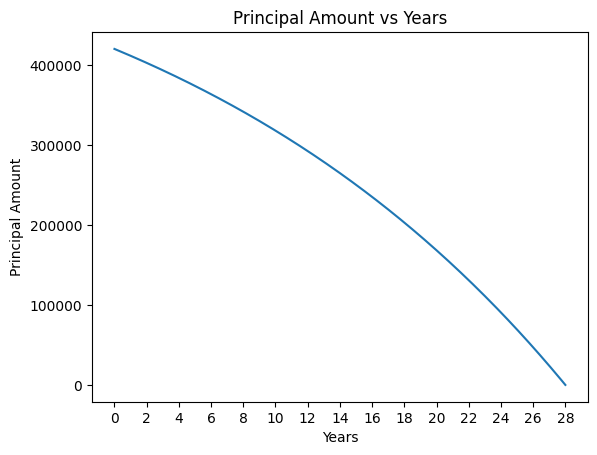

In [45]:
x = periodic_loan_calc.index
y = periodic_loan_calc['princip_remain']
plt.plot(x, y)
# Show ticks only for following values
period_tick = [i for i in x.to_list() if i % 24 == 0]
# While labelling ticks show them as years
plt.xticks(period_tick, labels=[str(int(i / 12)) for i in period_tick])
plt.xlabel("Years")
plt.ylabel("Principal Amount")
plt.title('Principal Amount vs Years')
plt.show()

## Marking the Interest paid until 5, 10, 15 years

In [131]:
cumm_interest_df = pd.DataFrame({"cumm_interest_paid": periodic_loan_calc['interest_paid_amt'].cumsum()})
interest_table = pd.concat([periodic_loan_calc['interest_paid_amt'], cumm_interest_df], axis=1)
print(interest_table)

# Calculate total interest paid every 5 year
every_five_year_cumm_interest = interest_table.loc[::12*5, ['cumm_interest_paid']].copy() # copy() as loc return reference to original df
tmp = every_five_year_cumm_interest.index.to_numpy() / 12
every_five_year_cumm_interest["year"] = tmp.astype(int)
every_five_year_cumm_interest.index.name = "month"

     interest_paid_amt  cumm_interest_paid
0                 0.00                0.00
1              1337.00             1337.00
2              1334.77             2671.77
3              1332.54             4004.31
4              1330.29             5334.60
..                 ...                 ...
332              32.62           264526.58
333              26.24           264552.82
334              19.84           264572.66
335              13.42           264586.08
336               6.97           264593.05

[337 rows x 2 columns]


       cumm_interest_paid  year
month                          
0                    0.00     0
60               76021.66     5
120             142337.45    10
180             196908.15    15
240             237266.26    20
300             260425.86    25


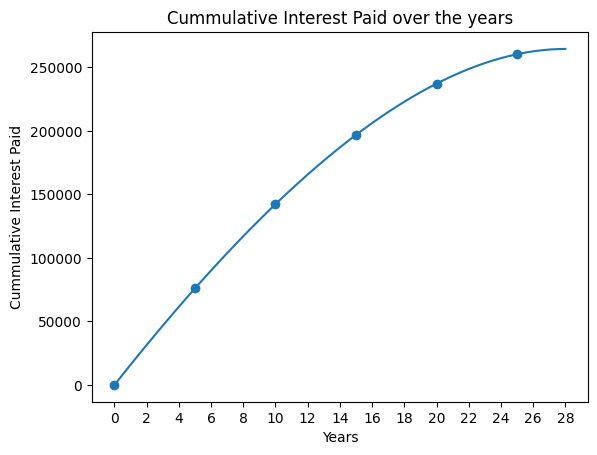

In [132]:
# Put markers of cummulative interest paid every 5 years
x = every_five_year_cumm_interest.index
y = every_five_year_cumm_interest['cumm_interest_paid'].to_numpy()
plt.scatter(x, y)
print(every_five_year_cumm_interest)

# Plot line for the cummulative interest
x = interest_table.index
y = interest_table['cumm_interest_paid']
plt.plot(x, y)
# Show ticks only for following values
period_tick = [i for i in x.to_list() if i % 24 == 0]
# While labelling ticks show them as years
plt.xticks(period_tick, labels=[str(int(i / 12)) for i in period_tick])
plt.xlabel("Years")
plt.ylabel("Cummulative Interest Paid")
plt.title('Cummulative Interest Paid over the years')
plt.show()

# Property Prices
## Berlin 
### Buying
Please follow this [page](https://hypofriend.de/en/property-prices-in-berlin.afb) to find the median prices per m2 in different regions of Berlin. 
1. The prices have increased by 10% each year until span of 6 years (from 2017 - 2023). 
2. Vacancy rate is the lowest of 0.91% and therefore, prices are still expected to rise. 
3. Berlin currently lacks more than 106.000 apartments. The calculation takes into account the difference between the number of inhabitants and the statistical household size minus the housing stock. 
### Renting
Please follow heading <em>Rental Market</em> in this [report](https://guthmann.estate/en/market-report/berlin/).
1. Renting an apartment can cost from around 700 € - 1500 € per month
2. Average asking rent can be from 10 - 16 € / m2 
3. Rent price was risen from 3 - 10 % from  Nov 2023 - Jan 2024